# 文書生成AIのファインチューニング・レシピ
本Notebookでは、RLHFによりファインチューニングしたモデルを評価するコードを記載します。

## 応用レシピ：独自の報酬モデルでファインチューニングしたモデルの評価

### (1) ライブラリのインストール
利用するライブラリをインストールします。

In [1]:
%pip install transformers==4.35.2
%pip install trl[peft]==0.7.10
%pip install wandb==0.16.2
%pip install sentencepiece==0.1.99
%pip install accelerate==0.26.1
%pip install bitsandbytes==0.42.0
%pip install datasets==2.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 92.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━

### (2) ライブラリのインポート

In [2]:
import torch
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

tqdm.pandas()

from transformers import (pipeline, AutoTokenizer,
                          AutoModelForSequenceClassification)
from transformers import AutoModelForCausalLM
from datasets import load_dataset
from peft import LoraConfig
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


### (3) モデル名とデータセット名の定義

In [3]:
rm1_name = 'Mizuiro-sakura/luke-japanese-base-marcja'
rm2_name = 'taku-yoshioka/reward_model'
base_model_name_for_reward = 'rinna/japanese-gpt2-medium'
model1_name = 'line-corporation/japanese-large-lm-1.7b'
model2_name = 'taku-yoshioka/rlhf_llm_custom_rm'
dataset_name, subset_name = 'shunk031/JGLUE', 'MARC-ja'

### (4) 報酬モデルの読み込み
報酬モデル自体の比較のため、`2-3_train-reward-model.ipynb`で訓練した報酬モデルをロードします。

In [4]:
device = 0
sentiment_pipe1 = pipeline("sentiment-analysis", model=rm1_name, device=device)
sentiment_pipe2 = pipeline("sentiment-analysis",
                           model=AutoModelForSequenceClassification.from_pretrained(rm2_name, num_labels=1),
                           tokenizer=AutoTokenizer.from_pretrained("rinna/japanese-gpt2-medium"),
                           device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/937 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/842k [00:00<?, ?B/s]

entity_vocab.json:   0%|          | 0.00/21.7M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/595 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at rinna/japanese-gpt2-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/282 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/806k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/153 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


### (5) 2つの報酬モデルの比較

In [5]:
def calc_rewards(dataset, sentiment_pipe1, sentiment_pipe2):
    reward1 = []
    reward2 = []

    for i, text in enumerate(tqdm(dataset)):
        r1 = sentiment_pipe1(text["review"], return_all_scores=True)[0][0]["score"]
        r2 = sentiment_pipe2(text["review"], return_all_scores=True)[0][0]["score"]
        reward1.append(r1)
        reward2.append(r2)
        if i > 1000:
            break

    df = pd.DataFrame({"reward1": reward1, "reward2": reward2})
    return df

In [6]:
sentiment_pipe2 = pipeline("sentiment-analysis",
                           model=AutoModelForSequenceClassification.from_pretrained(rm2_name, num_labels=1),
                           tokenizer=AutoTokenizer.from_pretrained(base_model_name_for_reward),
                           device=device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at rinna/japanese-gpt2-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for shunk031/JGLUE contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/shunk031/JGLUE
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


/root/.cache/huggingface/modules/datasets_modules/datasets/shunk031--JGLUE/bef660b0971cf102c95d2554bd2552ce5fb1cf8e9223cc6f8001c70be571c18c/JGLUE.py:464: UserWarning: can't import `mojimoji`, failing back to method that do nothing. We recommend running `pip install mojimoji` to reproduce the original preprocessing.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/187528 [00:00<?, ? examples/s]

  0%|          | 0/71819 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
  0%|          | 10/71819 [00:01<1:57:56, 10.15it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  1%|▏         | 1001/71819 [00:41<48:42, 24.23it/s]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

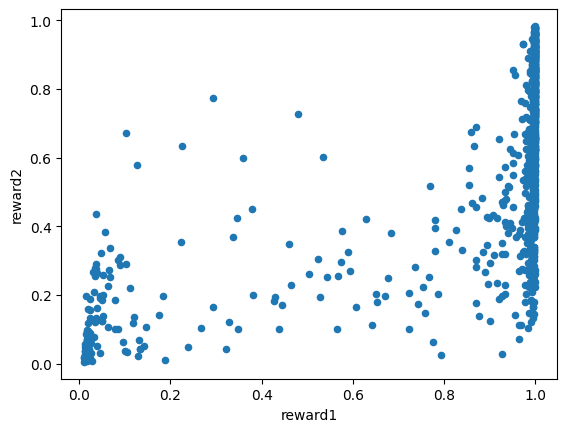

In [7]:
# データセットをロード、長さが200以上のサンプルを残す
ds = load_dataset(dataset_name, split="train", name=subset_name)
ds = ds.rename_columns({"sentence": "review"})
ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

df_ = calc_rewards(ds, sentiment_pipe1, sentiment_pipe2)
df_.plot.scatter("reward1", "reward2")
plt

### (6) ファインチューニング済みモデルの読み込み

In [8]:
pipe1 = pipeline('text-generation',
                 model=AutoModelForCausalLM.from_pretrained(model1_name),
                 tokenizer=AutoTokenizer.from_pretrained(model1_name)
                 )
pipe2 = pipeline('text-generation',
                 model=AutoModelForCausalLM.from_pretrained(model2_name),
                 tokenizer=AutoTokenizer.from_pretrained(model2_name)
                 )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/621 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

### (7) 推論
推論の対象となるデータセットをロードします。

In [9]:
def build_dataset(model_name, dataset_name, subset_name=None, split="train",
                  input_min_text_length=2, input_max_text_length=8):
    # トーカナイザをロード
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token

    # データセットをロード、長さが200以上のサンプルを残す
    ds = load_dataset(dataset_name, split=split, name=subset_name,
                      trust_remote_code=True)
    ds = ds.rename_columns({"sentence": "review"})
    ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

    # 各サンプルの長さをランダムに選ぶ
    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    # 入力サンプルに対して長さをランダムに選び、トークン列に変換
    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")

    return ds

In [10]:
dataset = build_dataset(model1_name, dataset_name, subset_name=subset_name,
                        split="train")

Filter:   0%|          | 0/187528 [00:00<?, ? examples/s]

Map:   0%|          | 0/71819 [00:00<?, ? examples/s]

In [11]:
dataset.to_pandas().head()

,review,label,review_id,input_ids,query
0,以前職場の方にこれをみて少しでも元氣になってくださいと手渡して、早３年。返してくれと一度言っ...,0,R2H83XHJUDZBHT,"[4964, 3752]",以前職場
1,ジュリアロバーツを初めて見たのがこの作品だったということは良かったのか悪かったのかわからない...,0,R3FRTU63ITKFKB,"[263, 37057, 759, 33062, 274]",ジュリアロバーツを
2,自殺志願者おじ、ヤクチューの祖父、引きこもり息子、破綻した父、 それを必死にまともてようとす...,0,R1X34GVUNQQKPX,"[263, 33466, 44853, 496, 26730]",自殺志願者おじ
3,大好きなＰＳＢの中でも１番好きなアルバムです。メロディラインの完成度，テクノを基本としながら...,0,R3A8Y91SEX0F2O,"[263, 4984, 3104, 404, 3831, 268]",大好きなPSBの中でも1
4,独特の世界は、男たちの挽歌時代から変わらない。登場人物（主役に偏る）の感情表現に重点を置き...,0,R38YCK808K11SG,"[263, 7907, 24900, 264, 30514]",独特の世界は、男たち


推論結果を評価するための関数を定義します。

In [12]:
def evaluate(dataset, pipe1, pipe2, sentiment_pipe):
    reward1 = []
    reward2 = []
    text1 = []
    text2 = []

    for i, text in tqdm(enumerate(dataset)):
        out1 = pipe1(text["query"], do_sample=False,
                    pad_token_id=pipe1.tokenizer.pad_token_id)
        out2 = pipe2(text["query"], do_sample=False,
                    pad_token_id=pipe2.tokenizer.pad_token_id)
        t1 = out1[0]["generated_text"]
        t2 = out2[0]["generated_text"]
        r1 = sentiment_pipe(t1, return_all_scores=True)[0][0]["score"]
        r2 = sentiment_pipe(t2, return_all_scores=True)[0][0]["score"]
        reward1.append(r1)
        reward2.append(r2)
        text1.append(t1)
        text2.append(t2)
        if i > 100:
            break

    df = pd.DataFrame({"reward1": reward1, "reward2": reward2,
                       "text1": text1, "text2": text2})
    return df


評価結果をデータフレームに格納します。

In [13]:
df = evaluate(dataset, pipe1, pipe2, sentiment_pipe1)

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
101it [07:40,  4.56s/it]


### (8) 結果の確認

In [14]:
df.head()

,reward1,reward2,text1,text2
0,0.970281,0.985085,以前職場が一緒だった人が、 10月1日に、 10年勤めた,以前職場が一緒だったメンバーで、 楽しく、明るく、元気に、 楽しく、明るく、
1,0.927496,0.995487,ジュリアロバーツを起用したCMは、2009年10月1日から,ジュリアロバーツをとても素敵に演じていて、本当にかっこよくて、本当にかっこよくて、本当に
2,0.832682,0.969824,自殺志願者おじちゃん 2018-09-25 19,自殺志願者おじさまが、 明るく楽しく、 楽しく、 楽しく、 楽しく
3,0.998600,0.998561,大好きなPSBの中でも1番好きなアルバムです。 1曲目の「Something,大好きなPSBの中でも1番大好きな曲です!ライブでも盛り上がるので、ぜひ一緒に盛り上がりましょう
4,0.997486,0.998526,独特の世界は、男たちのロマンを掻き立てる。 2019年10月,独特の世界は、男たちの心を熱く揺さぶり、そして元気にしてくれます。 明るく楽しく、そして


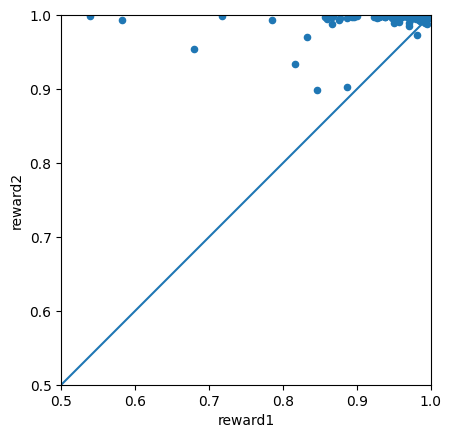

In [15]:
df.plot.scatter("reward1", "reward2")
plt.plot([0, 1], [0, 1])
plt.xlim([0.5, 1])
plt.ylim([0.5, 1])
plt.gca().set_aspect("equal")

In [16]:
df[["text1", "text2"]]

,text1,text2
0,以前職場が一緒だった人が、 10月1日に、 10年勤めた,以前職場が一緒だったメンバーで、 楽しく、明るく、元気に、 楽しく、明るく、
1,ジュリアロバーツを起用したCMは、2009年10月1日から,ジュリアロバーツをとても素敵に演じていて、本当にかっこよくて、本当にかっこよくて、本当に
2,自殺志願者おじちゃん 2018-09-25 19,自殺志願者おじさまが、 明るく楽しく、 楽しく、 楽しく、 楽しく
3,大好きなPSBの中でも1番好きなアルバムです。 1曲目の「Something,大好きなPSBの中でも1番大好きな曲です!ライブでも盛り上がるので、ぜひ一緒に盛り上がりましょう
4,独特の世界は、男たちのロマンを掻き立てる。 2019年10月,独特の世界は、男たちの心を熱く揺さぶり、そして元気にしてくれます。 明るく楽しく、そして
...,...,...
97,発売当時、私はまだ小学生で、 ゲームボーイのソフトは、 ほとんど遊んだことがありません,発売当時から人気の高かったアイテムも、より使いやすくなって登場。毎日の暮らしに彩りを添え
98,コメディー コメディー コメディー コメディー コメディー コメディー コメディ,コメディー要素もあり、とても楽しく、そしてとても勉強になり、本当に楽しく、そしてとても感動
99,このアルバムはすごい。 1曲目の「Something About You」から、,このアルバムはすごいです。ライブならではの迫力があり、ライブならではの楽しさがあり、ライブな...
100,すごく楽しみにしております。 2019年11月15日 11:,すごく楽しみにしております。 皆さまとお会いできること、 お会いできること、 心より楽しみに...


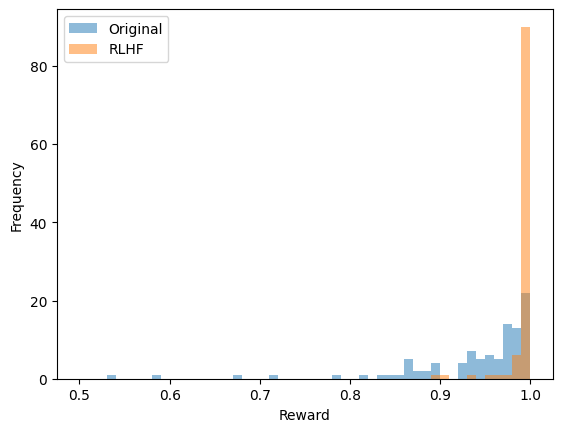

In [17]:
df["reward1"].hist(range=(0.5, 1), bins=50, alpha=0.5, label="Original")
df["reward2"].hist(range=(0.5, 1), bins=50, alpha=0.5, label="RLHF")
plt.gca().grid(False)
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.legend()

In [18]:
df[df["reward1"] < 0.9][["text1", "text2"]]

,text1,text2
2,自殺志願者おじちゃん 2018-09-25 19,自殺志願者おじさまが、 明るく楽しく、 楽しく、 楽しく、 楽しく
6,ノエルが何十人もの人間を殺して、その死体を焼いて、その死体を焼いて,ノエルが何十人もの仲間と力を合わせ、 大きな舞台で演奏できること、本当に本当に嬉しいです
9,ご存知の通り、 1000円札は、 1000円の価値,ご存知の方も多いと思いますが、 様々なジャンルの音楽が聴けて、 ジャンルも幅広くて、
11,内容:1. 2018年10月10日(水),内容もとってもおしゃれで、とっても使いやすくて、とってもおしゃれで、とっても使いやすくて、と...
13,これでCD、DVDを合わせて10000円以内で収まるでしょうか?<0x0A>補足すみません、,これでCD、DVDを合わせてもとってもお買い得価格なので、とってもとってもとってもとってもと...
27,2012年09月29日(土) 0 | 0,2012年11月1日(木)より、全国のローソン店舗にて
28,「芸術」と言われると、 私には、 芸術的センスが あるようには 思えない,「芸術」と言われる作品の数々。どれも本当に素晴らしくて、本当に楽しく、本当に感動できて、本当に
29,ムーランルージュ 2018-09-25 19:0,ムーランはとってもかわいくて、とってもかっこよくて、とってもかっこよくて、とってもかっこよく...
30,~音楽をジャンルで分類する~ 2018-09-25,~音楽をジャンルで楽しむ~ ジャンルにとらわれず、様々な音楽を聴き、音楽の素晴らしさを感じています
35,トロイの木馬 2018-09-25 19:,トロイの木馬です。 使いやすくてとても重宝しています。 シンプルで使いやすくてとても使いやすく
